In [44]:
import os
from PIL import Image
import numpy as np

from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import utils
import cv2
import numpy as np

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import transforms as T
import torch
import torchvision
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights, ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from dataset import COCO_dataformat
import engine

from torch.utils.data import Dataset, DataLoader

import math
import pandas as pd
from tqdm import tqdm


In [26]:
class COCO_dataformat(Dataset):
    def __init__(self, data_dir, transforms):
        super().__init__()
        self.dataset_path = '/home/seongwoo/workspace/DataScience_ML-DL/DL/assignment/trash_detection/data'
        # self.mode = mode
        self.transforms = transforms
        self.coco = COCO(data_dir)

        self.cat_ids = self.coco.getCatIds() # category id 반환
        self.cats = self.coco.loadCats(self.cat_ids) # category id를 입력으로 category name, super category 정보 담긴 dict 반환
        self.classNameList = ['Backgroud'] # class name 저장 
        for i in range(len(self.cat_ids)):
          self.classNameList.append(self.cats[i]['name'])

    def __getitem__(self, index):
        # image_id = self.coco.getImgIds(imgIds=index) # img id 또는 category id 를 받아서 img id 반환
        image_infos = self.coco.loadImgs(index)[0] # img id를 받아서 image info 반환
        
        # img_path = os.path.join(self.dataset_path, image_infos['file_name'])
        # images = Image.open(img_path).convert("RGB")

        # cv2 를 활용하여 image 불러오기(BGR -> RGB 변환 -> numpy array 변환 -> normalize(0~1))
        images = cv2.imread(os.path.join(self.dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images = images.transpose(2,0,1)
        images /= 255.0 # albumentations 라이브러리로 toTensor 사용시 normalize 안해줘서 미리 해줘야~
        images = torch.tensor(images)
        
        # if (self.mode in ('train', 'val')):
            # ann_ids = self.coco.getAnnIds(imgIds=image_infos['id']) #img id, category id를 받아서 해당하는 annotation id 반환
            # anns = self.coco.loadAnns(ann_ids) # annotation id를 받아서 annotation 정보 반환

            # # 저장된 annotation 정보로 label mask 생성, Background = 0, 각 pixel 값에는 "category id" 할당
            # masks = np.zeros((image_infos["height"], image_infos["width"]))
            # anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            # for i in range(len(anns)): # 이미지 하나에 존재하는 annotation 순회
            #     pixel_value = anns[i]['category_id'] # 해당 클래스 이름의 인덱스
            #     #className = classNameList[anns[i]['category_id']] # 클래스 이름
            #     masks[self.coco.annToMask(anns[i]) == 1] = pixel_value # coco.annToMask(anns) : anns 정보로 mask를 생성 / 객체가 있는 곳마다 객체의 label에 해당하는 mask 생성
            # masks = masks.astype(np.int8)
        ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
        anns = self.coco.loadAnns(ann_ids)

        target = {}

        bboxes = []
        labels = []
        image_id = []
        # masks = []
        for i in range(len(anns)):
            bbox = anns[i]['bbox']
            # masks.append(anns[i]["segmentation"])
            # area.append(anns[i]['area'])
            bboxes.append([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]])
            labels.append(anns[i]['category_id'])
            image_id.append(anns[i]['image_id'])

        boxes = torch.as_tensor(bboxes, dtype = torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype = torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.as_tensor(image_id)
        iscrowd = torch.zeros((len(anns),), dtype=torch.int64)

        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            images, target = self.transforms(images, target)

        return images, target

            # if self.transform is not None:
            #     transformed = self.transform(image=images, mask=masks)
            #     images = transformed["image"]
            #     masks = transformed["mask"]
            # return images, masks, image_infos
        
        # if self.mode == 'test':
        #     if self.transform is not None:
        #         transformed = self.transform(image=images)
        #         images = transformed["image"]
        #     return images, image_infos

    def __len__(self):
        return len(self.coco.getImgIds()) # 전체 dataset의 size 반환 


def get_transform(train):
    transforms = []
    # transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [27]:
coco = COCO('./data/train.json')
num_classes = len(coco.cats.keys())
num_classes

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!


11

In [28]:
classes = [i[1]['name'] for i in coco.cats.items()]
classes

['UNKNOWN',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [29]:
dataset_path = '/home/seongwoo/workspace/DataScience_ML-DL/DL/assignment/trash_detection/data' # Dataset 경로 지정 필요
train_path = dataset_path + '/train.json'
# val_path = dataset_path + '/val.json'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations
dataset = COCO_dataformat(train_path, get_transform(train=True))

loading annotations into memory...
Done (t=1.24s)
creating index...
index created!


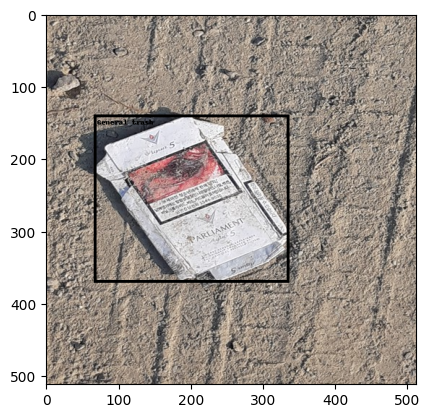

In [145]:
sample = dataset[4]
img_int = (sample[0] *255).type(torch.uint8)
plt.imshow(
    draw_bounding_boxes(img_int, sample[1]['boxes'], 
    [classes[i] for i in sample[1]['labels']], width=4).permute(1,2,0)
)

In [32]:
len(dataset)

2617

In [33]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의합니다
    
    # 분류기에서 사용할 입력 특징의 차원 정보를 얻습니다
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [34]:
data_loader = torch.utils.data.DataLoader(
                                        dataset, batch_size=4, shuffle=False, num_workers=4,
                                        collate_fn=utils.collate_fn)

In [37]:
device

device(type='cuda')

In [38]:
image, target = next(iter(data_loader))
image_list = list(images.to(device) for images in image)
targets = [{k: v.to(device) for k, v in t.items()} for t in target]
model = model.to(device)
output = model(image_list, targets)

In [42]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [47]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    all_losses = []
    all_losses_dict = []
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print(f'Epoch {epoch}, loss:{np.mean(all_losses).mean()}, loss_classifier: {all_losses_dict["loss_classifier"].mean()}, loss_box:{all_losses_dict["loss_box_reg"].mean()}, loss_rpn_box: {all_losses_dict["loss_rpn_box_reg"].mean()}, loss_object: {all_losses_dict["loss_objectness"].mean()} ')
    return all_losses_dict

In [49]:
num_epochs = 1
for epoch in range(num_epochs):
   all_loss_dict =  train_one_epoch(model, optimizer, data_loader, device, num_epochs)

100%|██████████| 655/655 [01:52<00:00,  5.83it/s]

Epoch 1, loss:0.5766410413702936, loss_classifier: 0.28351755221267694, loss_box:0.23579027103615627, loss_rpn_box: 0.027285625791121166, loss_object: 0.03004759177378955 


In [127]:
all_loss_dict.apply(lambda x: sum(x), axis=1).mean()

0.5766410408137439

In [102]:
print(f'Epoch {epoch}, loss:{all_loss_dict.apply(lambda x: sum(x), axis=1).mean()}, loss_classifier: {all_loss_dict["loss_classifier"].mean()}, loss_box:{all_loss_dict["loss_box_reg"].mean()}, loss_rpn_box: {all_loss_dict["loss_rpn_box_reg"].mean()}, loss_object: {all_loss_dict["loss_objectness"].mean()} ')

Epoch 0, loss:0.5766410408137439, loss_classifier: 0.28351755221267694, loss_box:0.23579027103615627, loss_rpn_box: 0.027285625791121166, loss_object: 0.03004759177378955 


In [167]:
test_dataloader = COCO_dataformat(train_path, get_transform(train=False))
data_loader_test_coco = torch.utils.data.DataLoader(
                                            test_dataloader, batch_size=1, shuffle=False, num_workers=4,
                                            collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


In [170]:
aa, _ = test_dataloader[10]
img_int_ = (aa *255).type(torch.uint8)
img_int_

tensor([[[193, 181, 133,  ..., 105,  94, 101],
         [136, 157, 141,  ...,  95,  89,  69],
         [107, 123, 171,  ..., 138, 134, 121],
         ...,
         [ 86, 153, 112,  ..., 121, 117, 140],
         [ 99, 137, 124,  ...,  69, 117, 132],
         [ 36,  84, 123,  ...,  68,  53,  86]],

        [[185, 173, 128,  ..., 105,  94, 101],
         [128, 149, 136,  ...,  95,  89,  69],
         [ 99, 115, 166,  ..., 138, 134, 121],
         ...,
         [ 86, 153, 112,  ..., 121, 117, 140],
         [ 99, 137, 124,  ...,  67, 115, 130],
         [ 36,  84, 123,  ...,  66,  51,  84]],

        [[183, 171, 125,  ..., 105,  94, 101],
         [126, 147, 133,  ...,  95,  89,  69],
         [ 96, 112, 162,  ..., 138, 134, 121],
         ...,
         [ 86, 153, 112,  ..., 121, 117, 140],
         [ 99, 137, 124,  ...,  68, 116, 131],
         [ 36,  84, 123,  ...,  67,  52,  85]]], dtype=torch.uint8)

In [174]:
img, _ = dataset[990]
img_int = (img *255).type(torch.uint8)
model.eval()
torch.cuda.empty_cache()
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]    

# plt.imshow(
#     draw_bounding_boxes(img_int, sample[1]['boxes'], 
#     [classes[i] for i in sample[1]['labels']], width=4).permute(1,2,0)
# )

In [148]:
prediction[0]

{'boxes': tensor([[2.4029e+02, 1.3813e+02, 3.6650e+02, 2.8011e+02],
         [1.6575e+02, 2.8571e+02, 3.2825e+02, 4.0093e+02],
         [2.8559e+02, 1.3339e+02, 3.6823e+02, 2.3997e+02],
         [0.0000e+00, 2.7298e+02, 5.6745e+01, 3.3689e+02],
         [1.7934e+02, 2.8807e+02, 2.6840e+02, 3.3325e+02],
         [2.4860e+02, 1.5279e+02, 3.3593e+02, 2.5298e+02],
         [2.2841e+02, 3.9945e+02, 2.4306e+02, 4.3498e+02],
         [1.7975e+02, 2.9060e+02, 2.6599e+02, 3.3239e+02],
         [2.4518e+02, 2.4513e+02, 3.4657e+02, 2.7931e+02],
         [2.3241e+01, 2.7621e+02, 1.5224e+02, 3.5650e+02],
         [3.0628e+01, 2.7945e+02, 1.5066e+02, 3.5576e+02],
         [1.7544e+02, 3.1080e+02, 1.9315e+02, 3.4008e+02],
         [2.4235e+02, 2.2133e+02, 3.5013e+02, 2.5004e+02],
         [2.4323e+01, 2.7894e+02, 1.5039e+02, 3.5638e+02],
         [1.6809e+02, 2.8953e+02, 3.2102e+02, 4.0607e+02],
         [1.9600e+02, 3.8335e+02, 2.6293e+02, 3.9928e+02],
         [2.5000e+01, 2.8016e+02, 1.4617e+02, 3

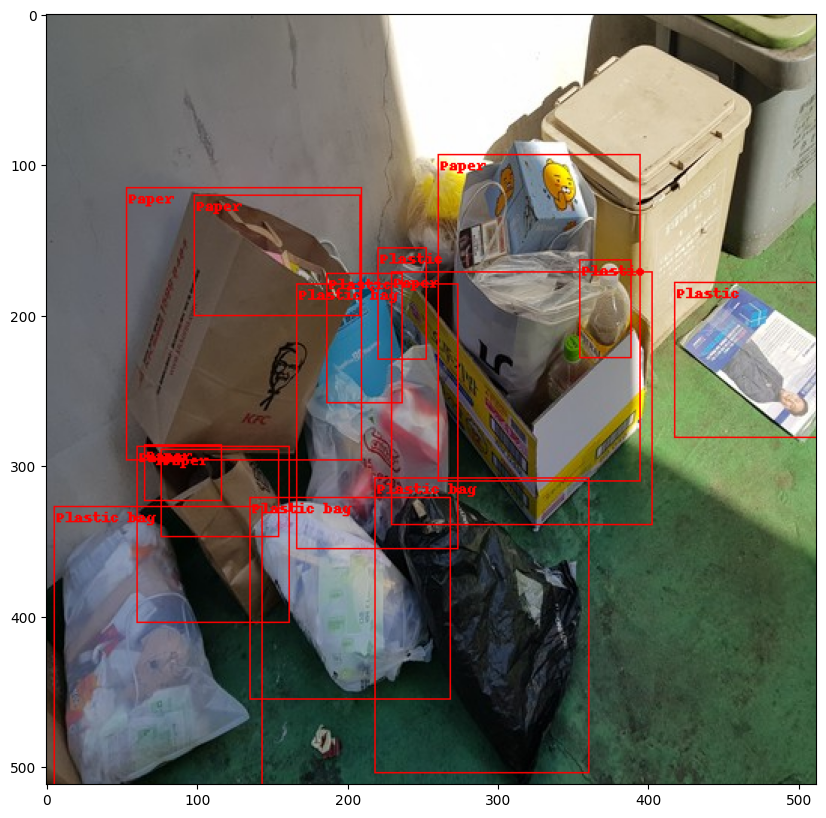

In [180]:
fig = plt.figure(figsize=(14,10))
plt.imshow(
    draw_bounding_boxes(img_int, pred['boxes'][pred['scores']>0.45], 
    [classes[i] for i in pred['labels'][pred['scores']>0.45].tolist()],
    colors = 'blue', width=1, font_size = 5).permute(1,2,0)
)

In [103]:
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

In [104]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [122]:
data_loader_test_coco.dataset

In [125]:
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()
    
    original_image_sizes: List[Tuple[int, int]] = []
    
    
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

ValueError: only one element tensors can be converted to Python scalars

In [7]:
coco = COCO('./data/train.json')
num_classes = len(coco.cats.keys())
num_classes

loading annotations into memory...
Done (t=1.35s)
creating index...
index created!


11